In [1]:
#%matplotlib inline
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/MEPS/')
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import createFolder as cF
import calc_date as cd
import plot_sfc_spaghetti_ret as spagh
import save_fig as SF
import get_Haukeli_obs_data as obsDat
import calc_48h_acc as acc
import fill_values as fv
import plot_vertical as pvert
from matplotlib.gridspec import GridSpec

import os

import pandas as pd
import matplotlib as mpl
mpl.style.use('ggplot')

In [21]:
year = 2016
month = 12
tid = '00'
#tid = '18'
station = 'Haukeliseter'
savefig = 1  # 1 = yes, 0 = no

### if plot with double fence data
dofe = 1     # 1 = yes, 0 = no

In [3]:
#### days 
#t = ['17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
t = ['20', '21', '22', '23', '24', '25', '26', '27']
#t = ['22']

In [4]:
champ = 255.
no1 = np.array([79,94,26])/champ
no2 = np.array([131,156,45])/champ
no3 = np.array([71,153,112])/champ
no4 = np.array([77,111,157])/champ
no5 = np.array([157,58,55])/champ
no6 = np.array([211,120,50])/champ
no7 = np.array([218,181,70])/champ

colors = [no1, no2, no3, no4, no5, no6, no7]

In [5]:
var_name = 'precipitation_amount_acc'
unit = '[mm]'
figdir = '../../Figures/Retrieval_MEPS/%s/ensemble_mean' %(var_name)
#figdir = '../../Figures/Retrieval/%s' %(var_name)
figdir_scatter = '../../Figures/Retrieval/%s/scatter' %var_name
# Folder where the figures are being saved    
cF.createFolder('%s/' %(figdir))
cF.createFolder('%s/' %(figdir_scatter))
form = 'png'

In [6]:
level = 'sfc'
### MEPS
ncdir_sfc = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
level = '10m'
ncdir_10m = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)


################################################################
### Haukeli obs.
txtdir = '../../Data/eklima/'
txt_filename = 'Observations-hour_minutes'

################################################################
### Retrieval 
nc_dir_retrieval = '../../Data/Retrieved_SWC'

################################################################



In [7]:
# read in the Haukeliseter observation file, sorted by daily values
Haukeli = pd.read_csv('%s/%s.txt' %(txtdir, txt_filename),\
                    sep = ';',header=19, skipfooter = 11, engine= 'python')

DateHour = Haukeli['Date-Hour(UTC)']

RR_1 = Haukeli['RR_1'].astype(float)           # Precipitation (1 hour); [mm]
DD   = Haukeli['DD'].astype(float)             # Wind direction (FF); [degrees]
FF   = Haukeli['FF'].astype(float)             # Wind speed (10 meters above ground);m/s

if tid == '18':
    precip, dt_precip, hour_precip, day_precip, month_precip, year_precip = obsDat.valid_values_18UTC(RR_1, DateHour)
    dt, p, hour, dy, mm, yr = obsDat.arange_daily_18UTC(RR_1, DateHour)
if tid == '00':
    precip, dt_precip, hour_precip, day_precip, month_precip, year_precip = obsDat.valid_values(RR_1, DateHour)
    dt, p, hour, dy, mm, yr = obsDat.arange_daily(RR_1, DateHour)

   

In [8]:
idxFF = np.where(FF[:] == -9999)
idxDD = np.where(DD[:] == -9999)

FF[idxFF[0][:]] = np.nan
DD[idxDD[0][:]] = np.nan

### calculate the U, V wind component for barb plot
# http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html

# first calculate the mathematical wind direction in deg
md_deg = 270 - DD
for k in range(0,md_deg.shape[0]):
    if md_deg[k] <0 :
        md_deg[k] = md_deg[k] +360
md_rad = math.pi/180. * md_deg
uwind = FF*np.cos(md_rad)
vwind = FF*np.sin(md_rad)

In [9]:
U_wind, V_wind, dt_wind, hour_wind, day_wind, month_wind, year_wind = obsDat.valid_values_wind(uwind, vwind, DateHour)

In [10]:
# read in the Haukeliseter observation file, for wind gust
Haukeli_gust = pd.read_csv('%s%s_gusts.txt' %(txtdir, txt_filename),\
                    sep = ';',header=14, skipfooter = 2,engine= 'python')
# FG_1 Kraftigste vindkast (siste time)
# FX_1 Kraftigste middelvind (siste time)
FX_1 = Haukeli_gust['FX_1'].astype(float)
DX_1 = Haukeli_gust['DX_1'].astype(float)

idxFX_1 = np.where(FX_1[:] == -9999)
idxDX_1 = np.where(DX_1[:] == -9999)

FX_1[idxFX_1[0][:]] = np.nan
DX_1[idxDX_1[0][:]] = np.nan

# first calculate the mathematical wind direction in deg
md_deg_X = 270 - DX_1
for k in range(0,md_deg_X.shape[0]):
    if md_deg_X[k] <0 :
        md_deg_X[k] = md_deg_X[k] +360
md_rad_X = math.pi/180. * md_deg_X
uwind_X = FX_1*np.cos(md_rad_X)
vwind_X = FX_1*np.sin(md_rad_X)

In [11]:
U_wind_X, V_wind_X, dt_wind_X, hour_wind_X, day_wind_X, month_wind_X, year_wind_X = obsDat.valid_values_wind(uwind_X, vwind_X, DateHour)

In [12]:
fn_sfc        = dict()
fn_10m        = dict()
time_sfc      = dict()
ini_day       = []
calday        = []
calmon        = []
precipitation_amount_acc = dict()
x_wind_10m    = dict()
y_wind_10m    = dict()
lead_time_sfc = dict()
title         = dict()

diff = dict()
day_diff_obs = []

Difference_0 = []
Difference_1 = []
Difference_2 = []
Difference_3 = []
Difference_4 = []
Difference_5 = []
Difference_6 = []
Difference_7 = []
Difference_8 = []
Difference_9 = []

Difference = []

all_day_max = []
all_day_min = []


calendar_day = []
initialisation_day = []
calendar_month = []
calendar_year = []
initialisation_hh = []

obs_var = []
obs_ret = []

In [13]:
def spaghetti_sfc_dofe(lead_time_sfc, variable, dofence_60, #time_sfc, 
              acc_ret,
              Xmax, day, time_precip_mean, precip_mean, var_name, 
              h_p18, m_p18, d_p18, y_p18, ini_day,
            unit, title, tid, doublefence):
    
    fig = plt.figure(figsize=(20,7))
    ax = plt.axes()
# Vertical line to show end of day
    ax.axvline(0,color = spagh.vert_col, linewidth = 3)
    ax.axvline(24,color = spagh.vert_col, linewidth = 3)
    ax.axvline(48,color = spagh.vert_col, linewidth = 3)

    if doublefence == 1:
## double fence    
        plt.plot(np.arange(0,49), np.asarray(dofence_60)[:], marker = 'H', markersize=20, 
            #color = spagh.dofe, 
                 linestyle = 'None', label = 'double fence')
## retrieval
    ax.plot(np.arange(0, np.asarray(acc_ret).shape[0]/60,1/60), acc_ret, linestyle = (0, (3, 1, 1, 1)), 
         color = no2, label = 'retrieved snowfall',linewidth=6)
## ensemble member         
    for ens_memb in range(2,10):
        ax.plot(lead_time_sfc[ens_memb][:], variable[ens_memb][:], color = spagh.memb_col,
           linestyle = '-', label='_nolegend_')
    ax.plot(lead_time_sfc[1][:], variable[1][:], color = spagh.memb_col,
           linestyle = '-', label = 'ensemble member')
    ax.plot(lead_time_sfc[0][:], variable[0][:], 'k', linewidth = 4, label = 'deterministic')
    ax.plot(time_precip_mean[:], np.asarray(precip_mean)[:], color='dodgerblue', linewidth = 3.5, 
            linestyle = '--', label = 'ensemble mean')  
    

### fine tuning
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.37),
          fancybox=True, shadow=True, ncol=3, fontsize=spagh.label_fs)
    frame = lgd.get_frame()
    frame.set_facecolor('white')

# yaxis
    ax.set_ylabel('%s %s %s' %(var_name[0], var_name[1], unit), fontsize=spagh.label_fs)
    ax.set_ylim(-0.5,80)
    T = np.arange(0,90,10)
    ax.set_yticks(T)
    ax.set_yticklabels(T,fontsize = spagh.tick_fs)

# xaxis
    a = lead_time_sfc[0][0:48]
    ax.set_xlim(-0.5,49-0.5)
    ax.set_xlabel('time', fontsize=spagh.label_fs)
    ax.set_xticks(np.arange(0,49,3))
    
    xdays = ['%s-%s-%s' %(year,month,ini_day), '',
        6,'',12,'', 18,'',
        '%s-%s-%s' %(year,month,ini_day+1), '',
        6,'', 12,'', 18,'',
        '%s-%s-%s' %(year,month,ini_day+2)]
    ax.set_xticklabels(xdays, rotation = 25, fontsize = spagh.tick_fs)
    

# title
    ax.set_title(title, fontsize=spagh.fontsize, color =spagh.blue )
# tight layout
    plt.tight_layout()
    
    return(lgd);

In [14]:
def spaghetti_sfc_dofe_wind(lead_time_sfc, lead_time_em, variable, dofence_60, #time_sfc, 
              acc_ret, uwind,vwind, uwind_dofe, vwind_dofe,
              Xmax, day, time_precip_mean, precip_mean, var_name, 
              h_p18, m_p18, d_p18, y_p18, ini_day,
            unit, title, tid, doublefence):
          
    fig = plt.figure(figsize=(20.,10))
    gs = GridSpec(10,1)
    gs.update(wspace=1., hspace=0.45)
    ax0 = fig.add_subplot(gs[:7,:])
    
# Vertical line to show end of day
    ax0.axvline(0,color = spagh.vert_col, linewidth = 3)
    ax0.axvline(24,color = spagh.vert_col, linewidth = 3)
    ax0.axvline(48,color = spagh.vert_col, linewidth = 3)

    
    if doublefence == 1:
## double fence    
        plt.plot(np.arange(0,49), np.asarray(dofence_60)[:], marker = 'H', markersize=20, 
            #color = spagh.dofe, 
                 linestyle = 'None', label = 'double fence')
## retrieval
    ax0.plot(np.arange(0, np.asarray(acc_ret).shape[0]/60,1/60), acc_ret, linestyle = (0, (3, 1, 1, 1)), 
         color = no2, label = 'retrieved snowfall',linewidth=6)
## ensemble member         
    for ens_memb in range(2,10):
        ax0.plot(lead_time_em[ens_memb][:], variable[ens_memb][:], color = spagh.memb_col,
           linestyle = '-', label='_nolegend_')
    ax0.plot(lead_time_em[1][:], variable[1][:], color = spagh.memb_col,
           linestyle = '-', label = 'ensemble member')
    ax0.plot(lead_time_em[0][:], variable[0][:], 'k', linewidth = 4, label = 'deterministic')
## ensemble mean
    ax0.plot(time_precip_mean[:], np.asarray(precip_mean)[:], color='dodgerblue', linewidth = 3.5, 
            linestyle = '--', label = 'ensemble mean')  
    
## Wind double fence
    ax2 = plt.subplot(gs[7:8,:])
    ax2.axvline(0,color = spagh.vert_col, linewidth = 3)
    ax2.axvline(24,color = spagh.vert_col, linewidth = 3)
    ax2.axvline(48,color = spagh.vert_col, linewidth = 3)
    ax2.barbs(lead_time_sfc[:48], np.zeros((lead_time_sfc[:48]).shape[0]),
               uwind_dofe[:], vwind_dofe[:], length = 7, pivot ='middle',linewidth=1.5)
    

### fine tuning
    lgd = ax0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.48),
          fancybox=True, shadow=True, ncol=3, fontsize=spagh.label_fs)
    frame = lgd.get_frame()
    frame.set_facecolor('white')
    



# yaxis
    ax0.set_ylabel('%s %s %s' %(var_name[0], var_name[1], unit), fontsize = spagh.label_fs)
    ax0.set_ylim(-0.8,80)
    T = np.arange(0,90,10)
    ax0.set_yticks(T)
    ax0.set_yticklabels(T,fontsize = spagh.fontsize)

# xaxis
    # xaxis
    
    
    a = lead_time_sfc[0:48]
    ax0.set_xlim(-0.5,49-0.5)
    ax0.set_xticks(np.arange(0,49,3))
    plt.setp(ax0.get_xticklabels(), visible=False) 


    xdays = ['%s-%s-%s' %(year,month,ini_day), '',
        6,'',12,'', 18,'',
        '%s-%s-%s' %(year,month,ini_day+1), '',
        6,'', 12,'', 18,'',
        '%s-%s-%s' %(year,month,ini_day+2)]

    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_xticks(lead_time_sfc[:(Xmax)])
    ax2.set_xlim([-0.5,49-0.5])
    ax2.set_ylim([-0.5,0.5])
    ax2.set_xticks(np.arange(0,49,3))
    ax2.set_xticklabels(xdays, rotation = 25, fontsize = spagh.tick_fs)
    ax2.set_xlabel('time', fontsize = spagh.label_fs)
# title
    ax0.set_title(title, fontsize=spagh.fontsize, color =spagh.blue )

    
    return(lgd);

In [15]:
#t = ['24','25']
for day in t:


    var_name_sfc = '%s' %(var_name)

    ## RETRIEVAL ######
    fn_ret1 = netCDF4.Dataset('%s/out_swc_b6_%s%s%s.nc' %(nc_dir_retrieval, year, month, day))
    fn_ret2 = netCDF4.Dataset('%s/out_swc_b6_%s%s%s.nc' %(nc_dir_retrieval, year, month, int(day)+1))
    equiv_accum1 = fn_ret1.variables['retrieved_snowfall_amount'][:,:] 
    equiv_accum2 = fn_ret2.variables['retrieved_snowfall_amount'][:,:] 


### calculate accumulation from retrieval
#srate = equiv_accum1[6,:]
    srate1 = (equiv_accum1[0,:])
    srate2 = (equiv_accum2[0,:])
    

#srate[np.where(~np.isfinite(srate))] = 0.0
#srate = srate/srate.shape[0]
    srate1[np.where(~np.isfinite(srate1))] = 0.0
    srate2[np.where(~np.isfinite(srate2))] = 0.0
    srate1 = srate1/srate1.shape[0]
    srate2 = srate2/srate2.shape[0]
    srate = np.concatenate((srate1, srate2),axis=0)
#pd.DataFrame(srate)

    acc_ret = []
    acc_ret.append(0.0)
    for i in range(0,srate.shape[0]-1):
        dix = np.nansum([acc_ret[i],srate[i]],axis = 0)
        acc_ret.append(dix)

    for ens_memb in range(0,10):
# read in the netcdf surface file
        fn_sfc[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s_%s.nc' %(ncdir_sfc,year,month,day,tid,ens_memb))
        time_sfc[ens_memb] = fn_sfc[ens_memb].variables['time']
        time_sfc[ens_memb] = fv.fill_nan(time_sfc[ens_memb][:])
# initialisation time for plotting
        ini_day = (datetime.datetime.utcfromtimestamp(time_sfc[0][0]).day)   # day of initialisation
        hh = (datetime.datetime.utcfromtimestamp(time_sfc[0][0]).hour)       # first hour of initialisation
        calday, calmon = cd.get_dayname(year, month, ini_day)
# Read in the variable name which should be plotted  
        precipitation_amount_acc[ens_memb] = fn_sfc[ens_memb].variables[var_name]
    
# read in the netcdf 10m wind file
        fn_10m[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s_%s.nc' %(ncdir_10m,year,month,day,tid,ens_memb))
# read in the wind variable
        x_wind_10m[ens_memb] = fn_10m[ens_memb].variables['x_wind_10m'][:]
        y_wind_10m[ens_memb] = fn_10m[ens_memb].variables['y_wind_10m'][:]
    



# lead time
        lead_time_sfc[ens_memb] = np.arange(0,time_sfc[ens_memb].shape[0])
# get only valuable values not nan
        #substitute missing values with nan 
        precipitation_amount_acc[ens_memb] = fv.fill_nan(precipitation_amount_acc[ens_memb][:,:])

#### save calendar day etc. for scatter plot
    calendar_day.append(calday)
    initialisation_day.append(ini_day)
    calendar_month.append(calmon)
    calendar_year.append(year)
    initialisation_hh.append(hh)
########
    
    
#### calculate every 60 min the accumulation over 48 hours
    tot = acc.accumulation_dt60_for48h(precip, ini_day)
################

# calculate the ensemble mean of ice amount (all 10 ensemble member averaged)
    val = np.zeros(shape=(10,np.asarray(precipitation_amount_acc[0])[::3].shape[0]))
    precip_std = []
    precip_mean = []
    for ens_memb in range(0,10):
        val[ens_memb] = np.asarray(precipitation_amount_acc[ens_memb])[::3,0]
    ### std, mean
    precip_std.append(np.nanstd(val,axis=0,ddof=1))
    precip_mean.append(np.mean(val,axis=0))
    
    time_precip_mean = lead_time_sfc[0][0:np.asarray(precipitation_amount_acc[0]).shape[0]:3]
#    time_precip_mean = lead_time_sfc[0][~np.isnan(precip_mean).any(axis=0)]
#    precip_mean = np.asarray(precip_mean)[~np.isnan(precip_mean)]
    

###################################
#### calculate the difference between DoFe and retrieval
    if day == '25':
        diff_obs = np.asarray(acc_ret)[0:60*41:60]-np.asarray(tot)[:41]
    elif day == '26':
        diff_obs = np.asarray(acc_ret)[0:60*17:60]-np.asarray(tot)[:17]
        
    diff_obs = np.asarray(acc_ret)[::60]-np.asarray(tot)[:-1]
    day_diff_obs.append(diff_obs) 
    
    

###################################

# get only valuable values not nan
    for ens_memb in range(0,10):
        time_sfc[ens_memb] = time_sfc[ens_memb][~np.isnan(time_sfc[ens_memb])]
        lead_time_sfc[ens_memb] = lead_time_sfc[ens_memb][~np.isnan(precipitation_amount_acc[ens_memb]).any(axis=1)]
        precipitation_amount_acc[ens_memb] = precipitation_amount_acc[ens_memb][~np.isnan(precipitation_amount_acc[ens_memb]).any(axis=1),:]
    
    
##########################################################
# spaghetti plot with all ensemble member + control
    if hh < 10:
        hh = '0%s' %(hh)
    else:
        hh = '%s' %(hh)
        

    
    title = 'initalised: %s, %s %s %s %s UTC' %(calday,ini_day,calmon,year,hh)
    var_name_sfc = var_name_sfc.split("_")
    
    if day == '25':
        Xmax = 41
    elif day == '26':
        Xmax = 17
    elif len(tot) <= 3:
        print('no double fence data')
        dofe = 0
        Xmax = 49
    else:
        dofe = 1
        Xmax = np.asarray(tot).shape[0]
    xwind_WM = []
    ywind_WM = []
    xwind_WM_gust = []
    ywind_WM_gust = []

    
    xwind_WM.extend(U_wind[int(day)-1][:])
    xwind_WM.extend(U_wind[int(day)][:])
    ywind_WM.extend(V_wind[int(day)-1][:])
    ywind_WM.extend(V_wind[int(day)][:])
    
    xwind_WM_gust.extend(U_wind_X[int(day)-1][:])
    xwind_WM_gust.extend(U_wind_X[int(day)][:])
    ywind_WM_gust.extend(V_wind_X[int(day)-1][:])
    ywind_WM_gust.extend(V_wind_X[int(day)][:])
    
    for ens_memb in range(0,10):
        fn_sfc[ens_memb].close()
        fn_10m[ens_memb].close()
    
       
    obs_ret.append(acc_ret)
    obs_var.append(tot)

##### PLOTTING ######
    fig_name = 'acc_%s%s%s_%s.png' %(year,month,ini_day,hh)
    lgd = spaghetti_sfc_dofe(lead_time_sfc, precipitation_amount_acc, tot, np.asarray(acc_ret)[:Xmax*60],
                             Xmax, day, time_precip_mean, np.asarray(precip_mean)[0,:], var_name_sfc,
                        hour, mm, dy, yr, int(ini_day), unit, title, tid, dofe)
    if savefig == 1:
        plt.savefig('%s/%s' % (figdir, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()

##### PLOTTING RETRIEVAL AND DOFE ######
#    fig_name = 'acc_%s%s%s_%s.png' %(year,month,ini_day,hh)
 #   for ens_memb in range(0,10):
  #      lead_time_sfc[ens_memb][:] = np.nan
   # time_precip_mean[:] = np.nan
    #lgd = spaghetti_sfc_dofe(lead_time_sfc, precipitation_amount_acc, tot, np.asarray(acc_ret)[:Xmax*60],
     #                        Xmax, day, time_precip_mean, np.asarray(precip_mean)[0,:], var_name_sfc,
      #                  hour, mm, dy, yr, int(ini_day), unit, '', tid, dofe)
#    if savefig == 1:
 #       plt.savefig('%s/%s' % (figdir, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
  #      print('plot saved: %s/%s' %(figdir,fig_name))
   # elif savefig == 0:
    #    plt.show()
#    plt.close()


    

#### with wind    
    fig_name = 'acc_wind_%s%s%s_%s.png' %(year,month,ini_day,hh)
   
    lgd = spaghetti_sfc_dofe_wind(lead_time_sfc[0], lead_time_sfc, precipitation_amount_acc, tot, np.asarray(acc_ret)[:Xmax*60],
                                  xwind_WM_gust, ywind_WM_gust,
                                  xwind_WM, ywind_WM,
                             Xmax, day, time_precip_mean, np.asarray(precip_mean)[0,:],var_name_sfc,
                        hour, mm, dy, yr, int(ini_day), unit, title, tid, dofe)
    
    
    if savefig == 1:
        plt.savefig('%s/%s' % (figdir, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()
    



    
        
   

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_20161220_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_wind_20161220_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_20161221_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_wind_20161221_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_20161222_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_wind_20161222_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_20161223_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_wind_20161223_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/acc_20161224_00.png
plot saved: ../../Figures/Retrieval_MEPS/precipitation_amount_acc/ensemble_mean/

In [16]:
def plt_all_day_diff(day_diff_obs,day_range,initialisation_day, calendar_month, calendar_year, initialisation_hh):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    # Vertical line to see if too high or too little
    ax.axvline(0, color =spagh.vert_col, linewidth=3)

    # Horizontal line to show end of day
    ax.axhline(0,color = spagh.vert_col, linewidth = 3)
    ax.axhline(24,color = spagh.vert_col, linewidth = 3)
    ax.axhline(48,color = spagh.vert_col, linewidth = 3)


    for i in day_range:
        if i == 5:
            Xmax = 41
        elif i == 6:
            Xmax = 17
        else:
            Xmax = np.asarray(day_diff_obs).shape[1]
        plt.scatter(day_diff_obs[i][:Xmax],np.arange(0,np.asarray(day_diff_obs[i][:Xmax]).shape[0]),
                            color = colors[i],
                        alpha = 0.8, s = 200,
                      label='%s %s %s 0%s UTC' %(initialisation_day[i],
                                            calendar_month[i],calendar_year[i],initialisation_hh[i]) )


        ### fine tuning
    lgd = ax.legend(loc='center left',bbox_to_anchor=(1, .75),
             fancybox=True, shadow=True, #ncol=3, 
              fontsize=spagh.label_fs-4)
    lgd.get_title().set_fontsize(spagh.label_fs-4)
    plt.setp(lgd.get_texts(), color=spagh.blue)


    #lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.37),
     #         fancybox=True, shadow=True, ncol=3, fontsize=spagh.label_fs)
    frame = lgd.get_frame()
    frame.set_facecolor('white')

    # yaxis
    #a = lead_time_sfc[0][0:48]
    ax.set_ylim(-0.5,49-0.5)
    ax.set_ylabel('time', fontsize=spagh.label_fs)
    ax.set_yticks(np.arange(0,49))

    xdays = [0, '', '', 3, '' , '',
            6,'','', 9,'','',12,'','',15,'','',18,'','',
             21, '','',
            24, '','',27, '','', 30, '','',
            33,'','', 36,'','',39,'','',42,'','',45,'','',
            48]
    ax.set_yticklabels(xdays, #rotation = 25, 
                       fontsize = spagh.tick_fs)

            # xaxis
    ax.set_xlim(-15,5)
    ax.set_xticks(np.arange(-15,10,5))
    ax.set_xticklabels(['', -10, '', 0, '', 10],fontsize = spagh.tick_fs)
    ax.set_title('Precipitation amount' , fontsize=spagh.fontsize)
    ax.set_xlabel('Difference [mm]', fontsize=spagh.fontsize)

    # tight layout
    plt.tight_layout()
    return(lgd)

In [31]:
def plt_scatter_all_days(obs_var,obs_ret,x_obs, intercept_obs,gradient_obs,
                         day_range, in_day, cal_mon,
                              cal_year,in_hh):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    for i in day_range:

        plt.scatter(np.asarray(obs_var)[i,:-1],
                    np.asarray(obs_ret)[i,:],color=colors[i],
                   alpha = 0.8, s = 150,
                          label='%s %s %s 0%s UTC' %(in_day[i],
                                                cal_mon[i],cal_year[i],in_hh[i]) )
    ax.plot(x_obs, intercept_obs + gradient_obs*x_obs,  
                    color ='k',
            alpha=0.7,
            label='y = {:.2f} + {:.2f}x'.format(intercept_obs, gradient_obs))
    
    ### fine tuning
    lgd = ax.legend(loc='center left',bbox_to_anchor=(1, .75),
             fancybox=True, shadow=True, #ncol=3, 
              fontsize=spagh.label_fs-4)
    lgd.get_title().set_fontsize(spagh.label_fs-4)
    plt.setp(lgd.get_texts(), color=spagh.blue)


    frame = lgd.get_frame()
    frame.set_facecolor('white')


    ax.plot([0,50], [0,50], linestyle = '-', color=spagh.memb_col)
            # yaxis
    ax.set_ylim(0,50)
    ax.set_yticks(np.arange(0,55,5))
    ax.set_yticklabels([0, '',10,'',20,'',30,'',40,'',50,'',60,'',70,'',80,'',90],fontsize = spagh.tick_fs)
            # xaxis
    ax.set_xlim(0,50)
    ax.set_xticks(np.arange(0,55,5))
    ax.set_xticklabels([0, '',10,'',20,'',30,'',40,'',50,'',60,'',70,'',80,'',90],fontsize = spagh.tick_fs)
    ax.set_title('Precipitation amount [mm]', fontsize=spagh.fontsize)

    

    ax.set_ylabel('retrieval', fontsize=spagh.label_fs)
    ax.set_xlabel('double fence', fontsize=spagh.label_fs)


        # tight layout
    plt.tight_layout()
    return(lgd)

In [18]:
day_range = np.arange(0,len(day_diff_obs)-1)
lgd = plt_all_day_diff(day_diff_obs,day_range,initialisation_day, calendar_month, calendar_year, initialisation_hh)
fig_name = 'diff_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

plot saved: ../../Figures/Retrieval/precipitation_amount_acc/scatter/diff_20161220_26_00.png


In [19]:
obs_ret = np.asarray(obs_ret)[:,::60]
obs_ret2 = np.asarray(obs_ret)
obs_ret2[5,41:] = np.nan
obs_ret2[6,17:] = np.nan



In [25]:
from scipy import stats
PP_obs_flat = np.ndarray.flatten(np.asarray(obs_var)[:,:-1])
PP_ret_flat = np.ndarray.flatten((obs_ret2)[:,:])

x_obs = np.asarray(PP_obs_flat)
y_obs = np.asarray(PP_ret_flat)
mask_obs = ~np.isnan(x_obs) & ~np.isnan(y_obs)
gradient_obs, intercept_obs, r_value, p_value, std_err = stats.linregress(x_obs[mask_obs],y_obs[mask_obs])

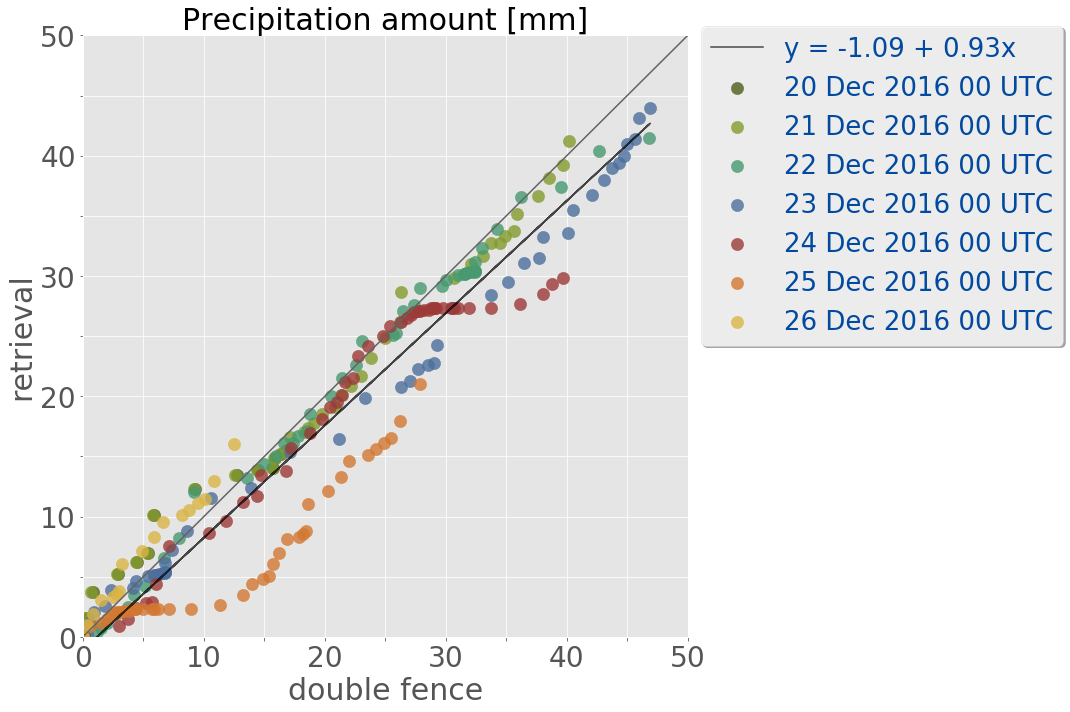

In [32]:
lgd = plt_scatter_all_days(obs_var,obs_ret2,x_obs,intercept_obs,gradient_obs,
                           day_range, initialisation_day, calendar_month,
                              calendar_year,initialisation_hh)
fig_name = 'obs_ret_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()